<a href="https://colab.research.google.com/github/ChenyuZhang16/nasa-space-app-sentry/blob/main/example/detect_landslide_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install required packages

In [1]:
 %matplotlib inline

In [ ]:
!pip install git+https://github.com/ChenyuZhang16/landslide-mapping-with-cnn.git
!pip install git+https://github.com/ChenyuZhang16/nasa-space-app-sentry.git
!pip install git+https://github.com/nargyrop/pyna.git
!pip install keplergl

In [3]:
from landslide_sentry.tiff_downloader import getROIFromTargetPoint, downloadEssentialTifFiles
from landslide_sentry.tiff_utils import preprocessTiffs
from landslide_sentry.cache_manager.cache_loader import loadFromCache

import os
import shutil

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=N6I7-929DBlr05Ak6d7RMc56jVXtpAm4FgCzNKDMRLk&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWhfgvLiZp1hl9XpegUzakmgXpFGgsJ7xYAQVE_IGfYB-taddS_4ADo

Successfully saved authorization token.


# Locate landslide events by exploring NASA Landslide Catalog

Users can directly access a pre-generated interactive map (access the html interactive map by running the code below). The output of this line will lead users to download a html file (link: https://drive.google.com/u/0/uc?id=1zttpFp3vrHMqCk6jkQOTAX_cFd1NoxIG&export=download). Download it and open it up, then you can explore the NASA Landslide Catalog! 

We use this interactive map to locate recent landslides by following the steps below:

1.Choose the window size of timeseries and limit the shown timeline to years after 2017 (when Sentinel-2 images are available). 

2.Click "Legend" button at right upper corner and find the color for different sizes of landslide events. Since Sentinel-2 mission provide 10-m resolution for Green,Red and Blue bands, small landslides might not be able to be detected. 

3.Click "Draw on map" button to draw on a polygon on the map, and then right click "Copy Geometry", then we get the coordinates of our Area of Interest (AOI) for neural network model inference later!       

To gain a better understanding of one specific landslide event, users can zoom in to the dot of each landslide event and click the dot. The detailed description about landslide sizes, categories, triggers and related links to look at photos and news. Users can zoom in and observe landslide ground details from our grayscale remote sensing base map (customized style with Mapbox studio).

We also provide codes in the next section if users want to play with the raw data from NASA and generate their own interactive maps. 

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

import pandas as pd
from keplergl import KeplerGl

# NASA Globbal Landslide Catalog Downloadable Products Gallery: https://maps.nccs.nasa.gov/arcgis/apps/MapAndAppGallery/index.html?appid=574f26408683485799d02e857e5d9521 
df = pd.read_csv(loadFromCache("nasa_global_landslide_catalog_point.csv"))

# Deal with NaN and re-organise data set for mapping
s2_df = df.loc[df['event_date'] > "2008-01-01 0:00"]
s2_df = s2_df.fillna("unknown")
s2_df['landslide_size'] = s2_df['landslide_size'].str.replace("very_large","large")

#Create a basemap with KeplerGL 
map = KeplerGl(height=800, width=800)
map.add_data(data=s2_df, name="Landslide events")
map

# Define Aera Of Interest (AOI)

In [5]:
latitude = 141.9
longitude = 42.8
aoi_width = 20
aoi_height = 20

roi = getROIFromTargetPoint(latitude, longitude, aoi_width, aoi_height)

# Define satellite data seeking range

In [6]:
pre_date_1 = '2017-07-20'
pre_date_2 = '2018-07-20'
post_date_1 = '2018-08-20'
post_date_2 = '2019-07-20'

The data downloader will seek between pre_date_1 and pre_date_2 for data before the landslide event, and between post_date_1 and post_date_2 for data after the event. These dates should satisfy: pre_date_1 < pre_date_2 < *landslide date* < post_date_1 < pre_date_2

# Download raw tiff files from Google Earth Engine

In [7]:
data_path = "./raw_data/"
if os.path.exists(data_path):
    shutil.rmtree(data_path)

pre_path = os.path.join(data_path, "pre")
post_path = os.path.join(data_path, "post")
dem_path = os.path.join(data_path, "dem")

downloadEssentialTifFiles(roi, pre_path, post_path, dem_path, pre_date_1, pre_date_2, post_date_1, post_date_2, 30)

preprocessTiffs(pre_path, post_path, data_path)


Encountered exception: <class 'ee.ee_exception.EEException'> - Image.select: Pattern 'B2' did not match any bands.
This could be due to level 2 data not available for the selected dates.
Try downloading alternative level 1 data (cloud mask not avaliable)


100%|██████████| 13.1M/13.1M [00:00<00:00, 31.1MiB/s]


100%|██████████| 15.1M/15.1M [00:00<00:00, 28.0MiB/s]
100%|██████████| 22.7k/22.7k [00:00<00:00, 4.06MiB/s]


100%|██████████| 398k/398k [00:00<00:00, 8.62MiB/s]
100%|██████████| 1.15M/1.15M [00:00<00:00, 15.1MiB/s]
100%|██████████| 322k/322k [00:00<00:00, 15.8MiB/s]


# Generate landslide map using neural network

In [8]:
from landslide_sentry.landslide_mapping import generateLandslideMap
from landslide_sentry.cache_manager.cache_loader import loadFromCache

result_path = "./landslide_mapping"

generateLandslideMap(loadFromCache("M_ALL_006.hdf5"), pre_path, post_path,
                    dem_path, result_path, data_path, debug=True)

TF Version --> 2.6.0
GDAL Version --> 2.2.3
OPEN CV Version --> 4.1.2
CURRENT WORKING DIR --> /content
1 Physical GPUs, 1 Logical GPUs
./landslide_mapping --> Folder exists!!!
5 files found in ./landslide_mapping --> Will be deleted.


100%|██████████| 256/256 [00:50<00:00,  5.04it/s]


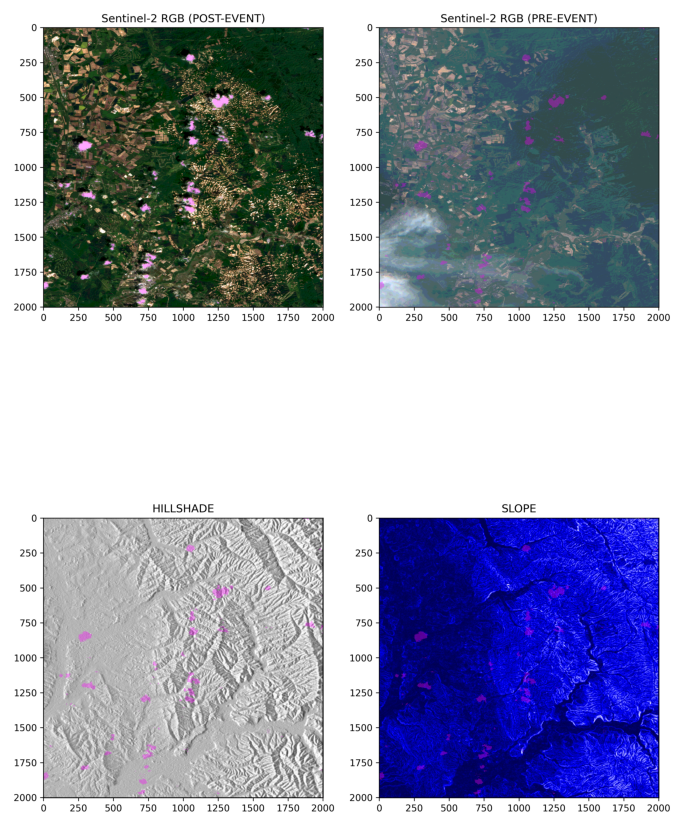

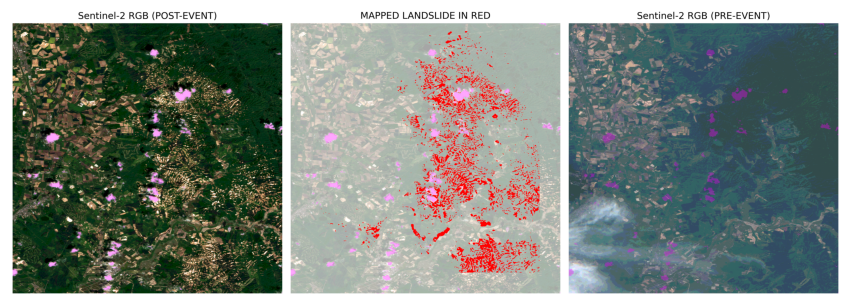

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(os.path.join(result_path, "raw_data_plot.png"))
fig, ax = plt.subplots(figsize=(12, 18))
ax.imshow(img)
ax.axis('off')
plt.show()

img = mpimg.imread(os.path.join(result_path, "prediction_plot.png"))
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(img)
ax.axis('off')
plt.show()